# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.26KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


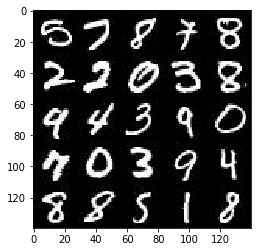

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

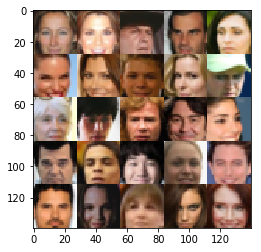

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None,z_dim), name='input_z')
    learningrate = tf.placeholder(tf.float32, None, name='learningrate')

    return input_real, input_z, learningrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [230]:
def discriminator(images, reuse=False,alpha =0.2,is_train=True, keep_probs=0.6):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3(depth)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1,keep_probs)
        # 14x14x64
        #print("Dx1",x1.get_shape().as_list())
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2,keep_probs)
        # 7x7x128
        #print("Dx2",x2.get_shape().as_list())
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding='valid',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3,keep_probs)
        # 3x3x256
        #print("Dx3",x3.get_shape().as_list())

        # Flatten it
        flat = tf.reshape(x3, (-1, 3*3*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [231]:
def generator(z, out_channel_dim, is_train=True,alpha = 0.2, keep_probs = 0.8):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1,keep_probs)
        # 3x3x256 now
        #print("Gx1",x1.get_shape().as_list())
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='valid',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2,keep_probs)
        # 7x7x128 now
        #print("Gx2",x2.get_shape().as_list())
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3,keep_probs)
        # 14x14x64 now
        #print("Gx3",x3.get_shape().as_list())
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout now
        
        out = tf.tanh(logits)
        #print("Gout",out.get_shape().as_list())
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [205]:
def model_loss(input_real, input_z,out_channel_dim,is_train=True,alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Gx1 [None, 3, 3, 256]
Gx2 [None, 7, 7, 128]
Gx3 [None, 14, 14, 64]
Gout [None, 28, 28, 4]
Dx1 [None, 14, 14, 64]
Dx2 [None, 7, 7, 128]
Dx3 [None, 3, 3, 256]
Dx1 [None, 14, 14, 64]
Dx2 [None, 7, 7, 128]
Dx3 [None, 3, 3, 256]
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [194]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [195]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [196]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,print_every=10):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learningrate = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    #print(data_shape[-1])
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2

                z_noise = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: z_noise})
                _ = sess.run(g_train_opt, feed_dict={input_z: z_noise,input_real:batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: z_noise})
                    train_loss_g = g_loss.eval({input_z: z_noise})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                                  "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.7349
Epoch 1/2... Discriminator Loss: 1.9678... Generator Loss: 0.8449
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 1.3563
Epoch 1/2... Discriminator Loss: 1.9246... Generator Loss: 0.8719
Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 1.1420
Epoch 1/2... Discriminator Loss: 1.3505... Generator Loss: 1.0634
Epoch 1/2... Discriminator Loss: 2.8796... Generator Loss: 0.5755
Epoch 1/2... Discriminator Loss: 1.1646... Generator Loss: 2.1135
Epoch 1/2... Discriminator Loss: 1.6849... Generator Loss: 1.5170
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 1.4283


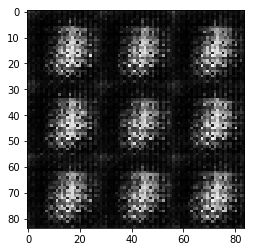

Epoch 1/2... Discriminator Loss: 0.4734... Generator Loss: 2.1204
Epoch 1/2... Discriminator Loss: 0.5352... Generator Loss: 1.8795
Epoch 1/2... Discriminator Loss: 0.4272... Generator Loss: 2.3555
Epoch 1/2... Discriminator Loss: 0.7354... Generator Loss: 2.0865
Epoch 1/2... Discriminator Loss: 0.2501... Generator Loss: 3.3445
Epoch 1/2... Discriminator Loss: 0.5740... Generator Loss: 2.8129
Epoch 1/2... Discriminator Loss: 0.6265... Generator Loss: 2.4999
Epoch 1/2... Discriminator Loss: 0.7032... Generator Loss: 1.6744
Epoch 1/2... Discriminator Loss: 0.5379... Generator Loss: 3.4400
Epoch 1/2... Discriminator Loss: 1.6324... Generator Loss: 1.4131


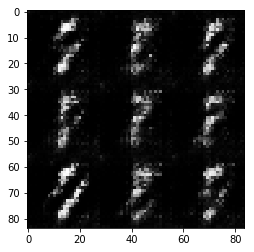

Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 1.2102
Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 1.6291
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 1.3266
Epoch 1/2... Discriminator Loss: 0.5500... Generator Loss: 2.3753
Epoch 1/2... Discriminator Loss: 0.5641... Generator Loss: 2.2143
Epoch 1/2... Discriminator Loss: 0.7487... Generator Loss: 2.2484
Epoch 1/2... Discriminator Loss: 0.6160... Generator Loss: 1.9386
Epoch 1/2... Discriminator Loss: 0.7594... Generator Loss: 1.7755
Epoch 1/2... Discriminator Loss: 0.8253... Generator Loss: 1.5145
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 1.1215


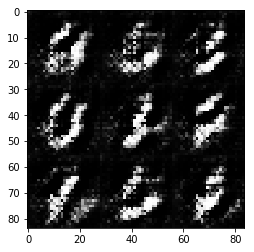

Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 1.2882
Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 1.8315
Epoch 1/2... Discriminator Loss: 1.0967... Generator Loss: 2.2456
Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 1.3932
Epoch 1/2... Discriminator Loss: 1.0830... Generator Loss: 1.2539
Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 1.9190
Epoch 1/2... Discriminator Loss: 0.8640... Generator Loss: 1.9785
Epoch 1/2... Discriminator Loss: 1.1956... Generator Loss: 1.1648
Epoch 1/2... Discriminator Loss: 1.0809... Generator Loss: 1.6669
Epoch 1/2... Discriminator Loss: 1.5411... Generator Loss: 0.9943


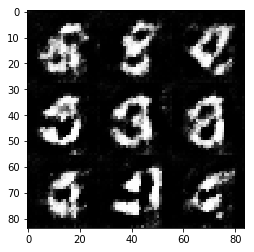

Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 1.1922
Epoch 1/2... Discriminator Loss: 1.0635... Generator Loss: 1.2911
Epoch 1/2... Discriminator Loss: 1.4790... Generator Loss: 1.0525
Epoch 1/2... Discriminator Loss: 1.0660... Generator Loss: 1.1682
Epoch 1/2... Discriminator Loss: 1.0793... Generator Loss: 1.1645
Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 1.1203
Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 1.1096
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 1.6386
Epoch 1/2... Discriminator Loss: 1.1819... Generator Loss: 1.4015
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 1.6392


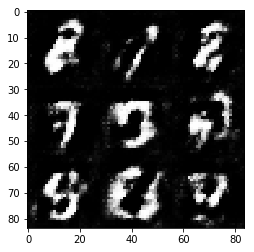

Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 1.1389
Epoch 1/2... Discriminator Loss: 1.0220... Generator Loss: 1.1867
Epoch 1/2... Discriminator Loss: 0.9404... Generator Loss: 1.3567
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 1.3694
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 1.4231
Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 1.2211
Epoch 1/2... Discriminator Loss: 0.9369... Generator Loss: 1.5094
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 1.6177
Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 1.2629
Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 1.0761


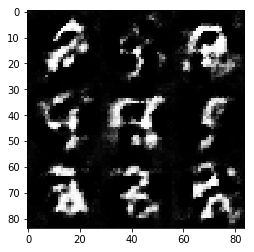

Epoch 1/2... Discriminator Loss: 0.9622... Generator Loss: 1.6849
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 1.4613
Epoch 1/2... Discriminator Loss: 0.8259... Generator Loss: 1.8785
Epoch 1/2... Discriminator Loss: 0.9605... Generator Loss: 1.7606
Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 1.3215
Epoch 1/2... Discriminator Loss: 1.1308... Generator Loss: 1.1810
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 1.1920
Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 1.4301
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.5464
Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 0.9000


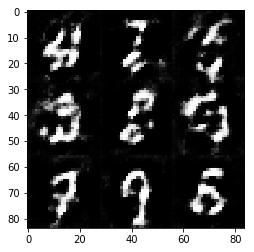

Epoch 1/2... Discriminator Loss: 1.0569... Generator Loss: 1.1642
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 1.7798
Epoch 1/2... Discriminator Loss: 1.1350... Generator Loss: 0.9626
Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 1.0179
Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 1.3772
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 1.1902
Epoch 1/2... Discriminator Loss: 0.7866... Generator Loss: 1.5520
Epoch 1/2... Discriminator Loss: 1.1685... Generator Loss: 1.0841
Epoch 1/2... Discriminator Loss: 0.9423... Generator Loss: 0.9227
Epoch 1/2... Discriminator Loss: 1.1682... Generator Loss: 1.3507


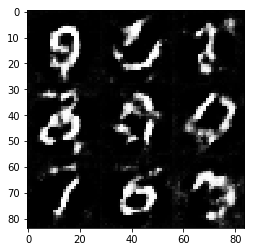

Epoch 1/2... Discriminator Loss: 1.1702... Generator Loss: 1.0292
Epoch 1/2... Discriminator Loss: 1.1126... Generator Loss: 0.9382
Epoch 1/2... Discriminator Loss: 0.9103... Generator Loss: 1.1200
Epoch 1/2... Discriminator Loss: 0.9972... Generator Loss: 1.3640
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 1.4370
Epoch 1/2... Discriminator Loss: 1.0956... Generator Loss: 0.9245
Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 1.6123
Epoch 1/2... Discriminator Loss: 1.2423... Generator Loss: 1.0329
Epoch 1/2... Discriminator Loss: 0.9859... Generator Loss: 1.3278
Epoch 1/2... Discriminator Loss: 1.0513... Generator Loss: 0.8685


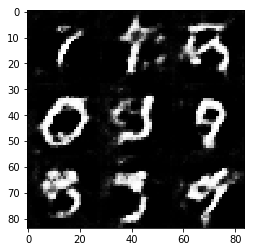

Epoch 1/2... Discriminator Loss: 1.0449... Generator Loss: 1.1330
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.8120
Epoch 1/2... Discriminator Loss: 0.9761... Generator Loss: 1.0861
Epoch 2/2... Discriminator Loss: 1.0273... Generator Loss: 1.0920
Epoch 2/2... Discriminator Loss: 1.1865... Generator Loss: 0.8669
Epoch 2/2... Discriminator Loss: 1.2544... Generator Loss: 1.2076
Epoch 2/2... Discriminator Loss: 0.9930... Generator Loss: 1.1597
Epoch 2/2... Discriminator Loss: 1.1895... Generator Loss: 0.6552
Epoch 2/2... Discriminator Loss: 1.0806... Generator Loss: 1.1385
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.6492


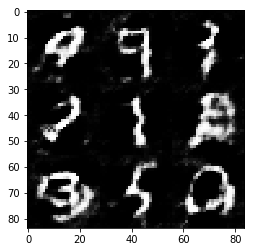

Epoch 2/2... Discriminator Loss: 1.2373... Generator Loss: 0.6864
Epoch 2/2... Discriminator Loss: 0.8372... Generator Loss: 1.4056
Epoch 2/2... Discriminator Loss: 1.1260... Generator Loss: 0.9468
Epoch 2/2... Discriminator Loss: 1.2866... Generator Loss: 1.3401
Epoch 2/2... Discriminator Loss: 0.8255... Generator Loss: 1.7832
Epoch 2/2... Discriminator Loss: 1.1172... Generator Loss: 1.5164
Epoch 2/2... Discriminator Loss: 1.2008... Generator Loss: 1.0763
Epoch 2/2... Discriminator Loss: 1.4142... Generator Loss: 1.2556
Epoch 2/2... Discriminator Loss: 1.0131... Generator Loss: 1.1684
Epoch 2/2... Discriminator Loss: 1.0246... Generator Loss: 0.8484


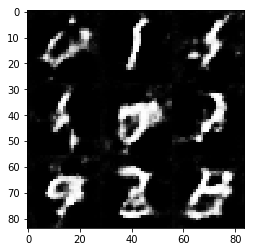

Epoch 2/2... Discriminator Loss: 1.0550... Generator Loss: 1.0706
Epoch 2/2... Discriminator Loss: 1.1399... Generator Loss: 0.7796
Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 1.1627
Epoch 2/2... Discriminator Loss: 1.0250... Generator Loss: 1.1382
Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 1.5380
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 1.4795
Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 0.9993
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 1.1006
Epoch 2/2... Discriminator Loss: 1.1648... Generator Loss: 1.6722
Epoch 2/2... Discriminator Loss: 1.1242... Generator Loss: 0.7287


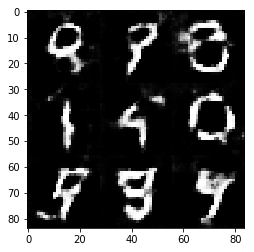

Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 1.2978
Epoch 2/2... Discriminator Loss: 1.0764... Generator Loss: 1.9103
Epoch 2/2... Discriminator Loss: 1.0115... Generator Loss: 1.5389
Epoch 2/2... Discriminator Loss: 1.0065... Generator Loss: 1.3437
Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 1.1585
Epoch 2/2... Discriminator Loss: 0.9548... Generator Loss: 1.1963
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 1.3406
Epoch 2/2... Discriminator Loss: 1.0509... Generator Loss: 0.9583
Epoch 2/2... Discriminator Loss: 1.1278... Generator Loss: 1.2220
Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 0.8954


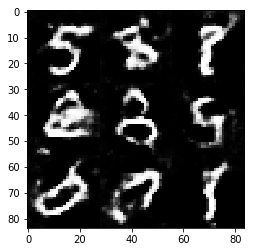

Epoch 2/2... Discriminator Loss: 1.2891... Generator Loss: 1.2119
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 1.2785
Epoch 2/2... Discriminator Loss: 1.0793... Generator Loss: 1.2584
Epoch 2/2... Discriminator Loss: 1.2319... Generator Loss: 1.2000
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 1.1951
Epoch 2/2... Discriminator Loss: 1.0955... Generator Loss: 1.0022
Epoch 2/2... Discriminator Loss: 1.2475... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 0.9964... Generator Loss: 1.3705
Epoch 2/2... Discriminator Loss: 0.9927... Generator Loss: 0.9797
Epoch 2/2... Discriminator Loss: 0.9539... Generator Loss: 1.4606


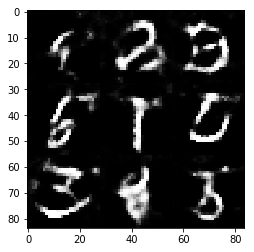

Epoch 2/2... Discriminator Loss: 1.2071... Generator Loss: 1.1128
Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 1.1070
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 1.3025
Epoch 2/2... Discriminator Loss: 1.0458... Generator Loss: 0.8393
Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 1.1234
Epoch 2/2... Discriminator Loss: 1.1214... Generator Loss: 0.8286
Epoch 2/2... Discriminator Loss: 1.1759... Generator Loss: 1.0808
Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 0.9924
Epoch 2/2... Discriminator Loss: 0.9059... Generator Loss: 1.1996
Epoch 2/2... Discriminator Loss: 1.0959... Generator Loss: 1.2075


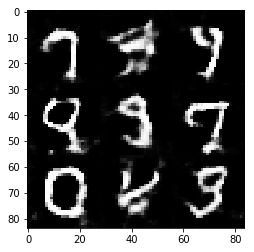

Epoch 2/2... Discriminator Loss: 0.9400... Generator Loss: 1.6911
Epoch 2/2... Discriminator Loss: 1.1119... Generator Loss: 1.4463
Epoch 2/2... Discriminator Loss: 1.0488... Generator Loss: 0.9785
Epoch 2/2... Discriminator Loss: 1.2101... Generator Loss: 0.8468
Epoch 2/2... Discriminator Loss: 1.3062... Generator Loss: 0.9434
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: 0.8664
Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 0.8519
Epoch 2/2... Discriminator Loss: 1.0580... Generator Loss: 0.8230
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 1.5739
Epoch 2/2... Discriminator Loss: 1.1067... Generator Loss: 1.1942


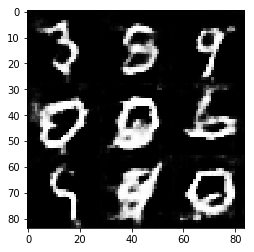

Epoch 2/2... Discriminator Loss: 1.0342... Generator Loss: 1.0084
Epoch 2/2... Discriminator Loss: 1.2549... Generator Loss: 0.9000
Epoch 2/2... Discriminator Loss: 1.4415... Generator Loss: 0.9135
Epoch 2/2... Discriminator Loss: 1.0747... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 0.9843... Generator Loss: 0.9785
Epoch 2/2... Discriminator Loss: 1.1353... Generator Loss: 1.0023
Epoch 2/2... Discriminator Loss: 1.0382... Generator Loss: 0.9758
Epoch 2/2... Discriminator Loss: 1.0874... Generator Loss: 1.2230
Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 1.3133
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 1.4934


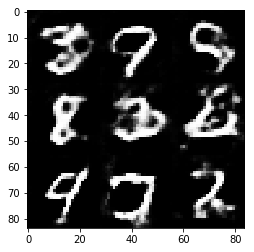

Epoch 2/2... Discriminator Loss: 1.0990... Generator Loss: 1.4142
Epoch 2/2... Discriminator Loss: 0.9323... Generator Loss: 1.1373
Epoch 2/2... Discriminator Loss: 1.0348... Generator Loss: 1.2287
Epoch 2/2... Discriminator Loss: 1.1328... Generator Loss: 1.4065
Epoch 2/2... Discriminator Loss: 0.9877... Generator Loss: 1.4685
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 1.1346
Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 1.3982
Epoch 2/2... Discriminator Loss: 1.1193... Generator Loss: 1.0997
Epoch 2/2... Discriminator Loss: 1.0655... Generator Loss: 1.0002
Epoch 2/2... Discriminator Loss: 1.2487... Generator Loss: 1.1070


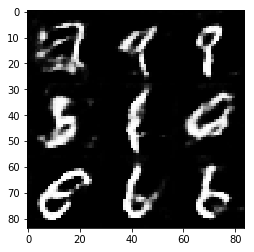

Epoch 2/2... Discriminator Loss: 1.0103... Generator Loss: 0.9510
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 1.0727
Epoch 2/2... Discriminator Loss: 0.9511... Generator Loss: 1.4165
Epoch 2/2... Discriminator Loss: 1.0387... Generator Loss: 1.5986
Epoch 2/2... Discriminator Loss: 0.9167... Generator Loss: 1.1749
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 1.4820
Epoch 2/2... Discriminator Loss: 1.1103... Generator Loss: 1.2627


In [238]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.35


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.2036
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 1.2964
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 1.5714
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 1.9956
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 1.9716
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 2.3209
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 2.5126
Epoch 1/1... Discriminator Loss: 0.6369... Generator Loss: 2.6912
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 1.7999


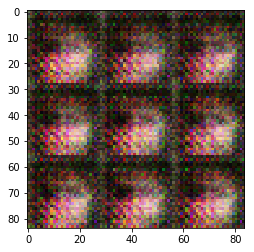

Epoch 1/1... Discriminator Loss: 0.3177... Generator Loss: 2.5486
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 1.4631
Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 1.8357
Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 1.6222
Epoch 1/1... Discriminator Loss: 0.2381... Generator Loss: 3.4607
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.5731
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 1.7120
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 2.9292
Epoch 1/1... Discriminator Loss: 0.3728... Generator Loss: 3.3987


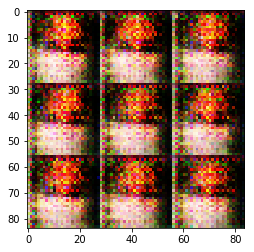

Epoch 1/1... Discriminator Loss: 0.2674... Generator Loss: 4.8621
Epoch 1/1... Discriminator Loss: 0.2792... Generator Loss: 2.8452
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 3.4467
Epoch 1/1... Discriminator Loss: 0.2106... Generator Loss: 3.7877
Epoch 1/1... Discriminator Loss: 0.2056... Generator Loss: 2.3188
Epoch 1/1... Discriminator Loss: 0.0974... Generator Loss: 4.0805
Epoch 1/1... Discriminator Loss: 0.1047... Generator Loss: 3.9599
Epoch 1/1... Discriminator Loss: 0.0988... Generator Loss: 3.3815
Epoch 1/1... Discriminator Loss: 0.1621... Generator Loss: 3.0734
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 3.1266


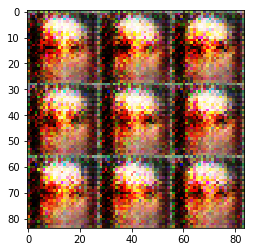

Epoch 1/1... Discriminator Loss: 0.2852... Generator Loss: 2.4107
Epoch 1/1... Discriminator Loss: 0.3161... Generator Loss: 3.0309
Epoch 1/1... Discriminator Loss: 0.3224... Generator Loss: 2.6563
Epoch 1/1... Discriminator Loss: 0.0938... Generator Loss: 4.0520
Epoch 1/1... Discriminator Loss: 0.1097... Generator Loss: 3.9375
Epoch 1/1... Discriminator Loss: 0.2107... Generator Loss: 3.1596
Epoch 1/1... Discriminator Loss: 0.2523... Generator Loss: 2.9866
Epoch 1/1... Discriminator Loss: 0.2254... Generator Loss: 4.6419
Epoch 1/1... Discriminator Loss: 0.1873... Generator Loss: 2.9342
Epoch 1/1... Discriminator Loss: 0.1940... Generator Loss: 6.2320


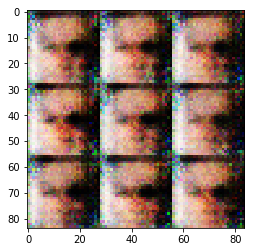

Epoch 1/1... Discriminator Loss: 0.1075... Generator Loss: 4.1093
Epoch 1/1... Discriminator Loss: 0.2417... Generator Loss: 3.0942
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 2.4757
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 4.1043
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.1020
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.3683
Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 2.5816
Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 1.5756
Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 1.5035
Epoch 1/1... Discriminator Loss: 0.5890... Generator Loss: 3.7920


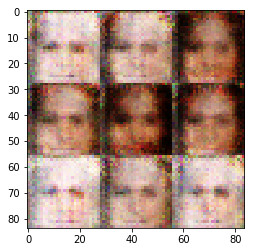

Epoch 1/1... Discriminator Loss: 0.4493... Generator Loss: 2.3310
Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 3.9393
Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 2.3896
Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 1.9687
Epoch 1/1... Discriminator Loss: 0.3908... Generator Loss: 1.5573
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 3.4184
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 2.8047
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 2.4874


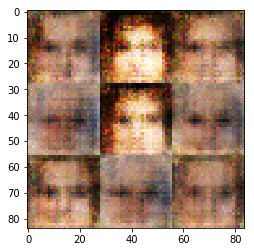

Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.5908
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.7749
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 1.9293
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 2.2665
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 1.3369
Epoch 1/1... Discriminator Loss: 0.3392... Generator Loss: 2.1574
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 3.1453
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 1.4942
Epoch 1/1... Discriminator Loss: 0.5735... Generator Loss: 2.9455


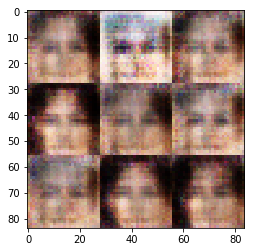

Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 2.2763
Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 2.4505
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 1.5435
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 3.1067
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 2.4093
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 2.5238
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 2.5809


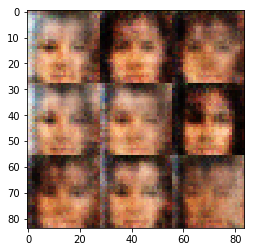

Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.7819
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.8790
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 1.9011
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 2.3765
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 1.9164
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 1.5880


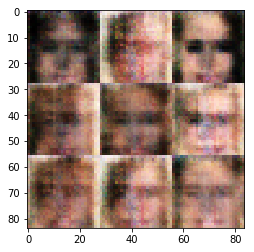

Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 1.6532
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 1.6892
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 2.1815
Epoch 1/1... Discriminator Loss: 0.6562... Generator Loss: 1.7219
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.3977
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.7245


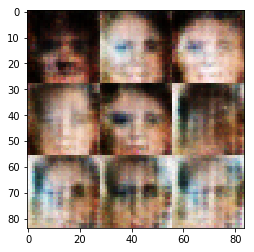

Epoch 1/1... Discriminator Loss: 0.6758... Generator Loss: 1.7907
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 2.3849
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.3332
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 1.8899
Epoch 1/1... Discriminator Loss: 0.7435... Generator Loss: 1.7906
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 2.0425
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 2.1639
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 1.7851
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 1.5327


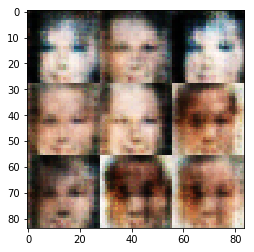

Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 1.4099
Epoch 1/1... Discriminator Loss: 0.5521... Generator Loss: 1.8756
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.9273
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 2.0992
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.9258
Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 1.1927
Epoch 1/1... Discriminator Loss: 0.5784... Generator Loss: 1.7410
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 1.1544
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 1.3794


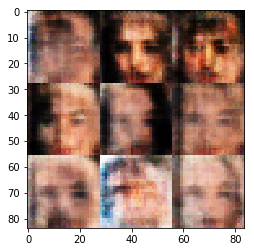

Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.9802
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 2.3836
Epoch 1/1... Discriminator Loss: 0.6136... Generator Loss: 1.7036
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.6692
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 1.8446
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.4351
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 2.0803
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 1.6616
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.9503


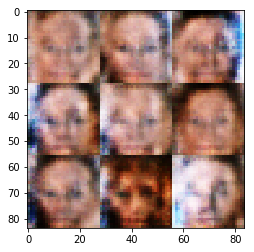

Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 1.1719
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 1.6927
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 1.5766
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 1.7661
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 1.4213
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 1.5727
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.3143


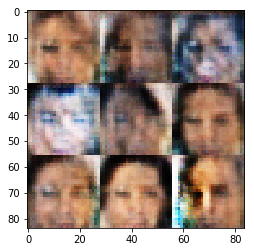

Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 1.4672
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.5446
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.0739
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 1.0941


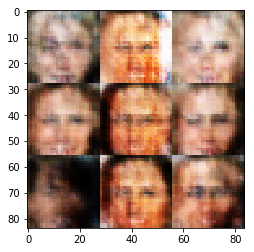

Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 1.4447
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.2726
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 1.8851
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.5226


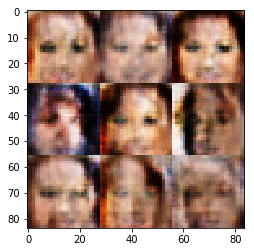

Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 1.4909
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.0174
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.7050
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.2900
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 1.6483
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 1.3147
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.1534


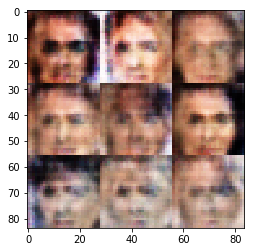

Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 1.4348
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 1.4166
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.7704
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 1.2489


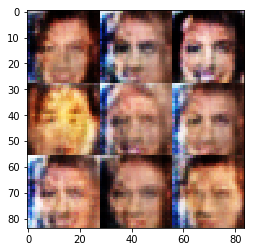

Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 1.1966
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.4273
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 1.2586
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.3391
Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 1.1741


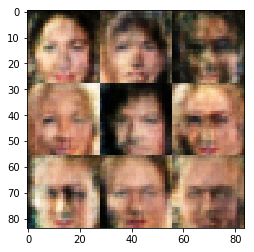

Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 1.1082
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.4435
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.3444
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.2700


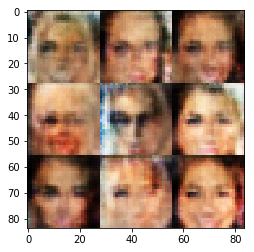

Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.1365
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 1.3479
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.6475
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 1.1876
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.5748


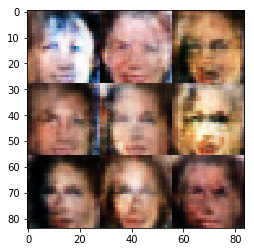

Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.1561
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.1913
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.1310
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 1.1630
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.5606
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.9498


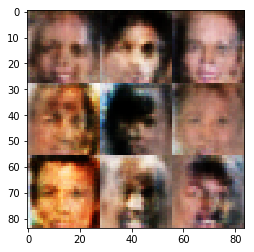

Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 1.0668
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.4151
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 1.4601
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 1.1256
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 1.2075


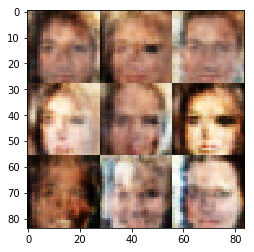

Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 1.4585
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 1.6088
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.2830


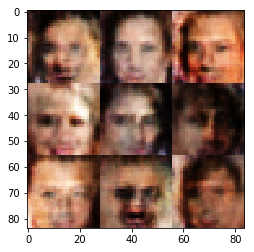

Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 1.1786
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.2440
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.9694


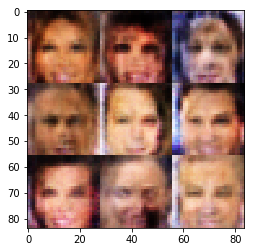

Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 1.3183
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 1.5142
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 1.5910
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 0.7308


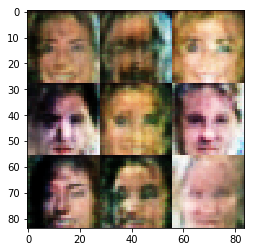

Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 1.0967
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 1.1139
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 1.1443
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 1.2257


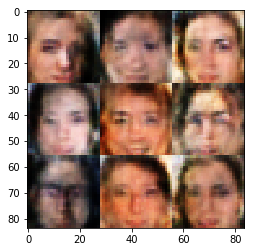

Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.1869


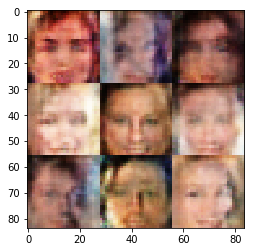

Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.9781
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 1.0948
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 1.0138


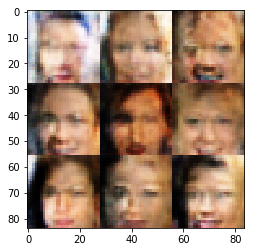

Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 1.2236
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.4785
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 1.3061


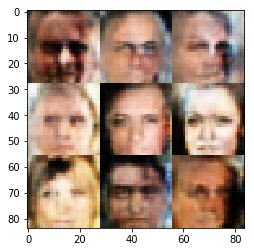

Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 1.1650
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 1.0755


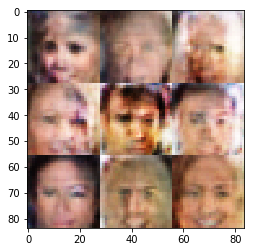

Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 1.0478
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 1.1493
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 0.8950


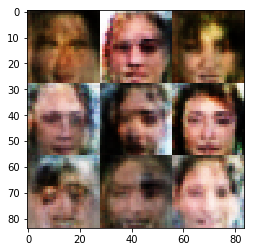

Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 1.3948
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 1.7096
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 1.1644
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.8953


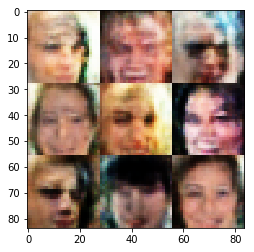

Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 1.2162
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 1.1164
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.2355
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.9920


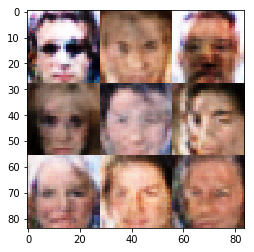

Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.1402


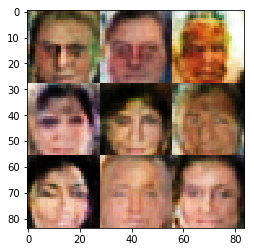

Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 1.2819
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.1645
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 1.0067


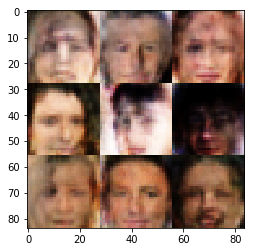

Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.6289... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 1.1184
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.7598


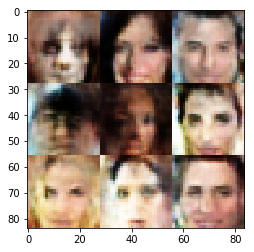

Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 1.2815
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.3030
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.9683


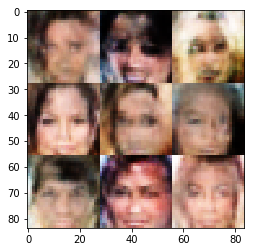

Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 1.1366
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 1.2900
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 1.0656


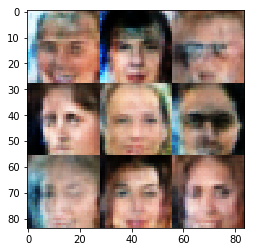

Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 1.1384
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.1695
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.8028


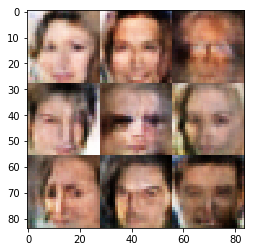

Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.5030
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 1.3188
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.0693
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.2730
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 0.9664


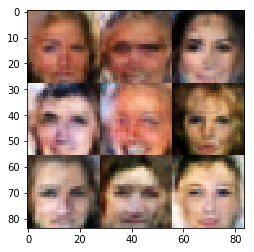

Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 1.0757
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 1.3917
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 1.0912


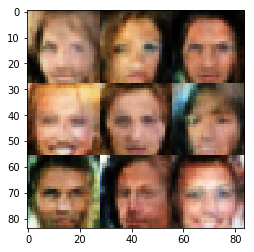

Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 1.2414
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 1.1991
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.2000
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.2324


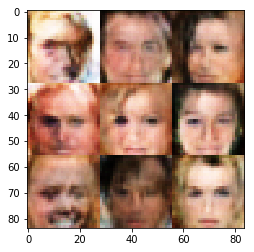

Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 1.0894
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.6252


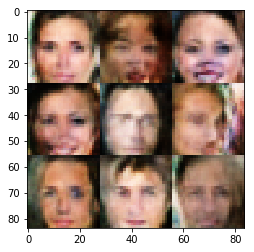

Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.9694


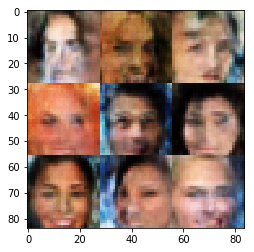

Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 1.1847
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.6546


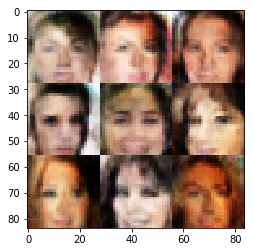

Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.9239


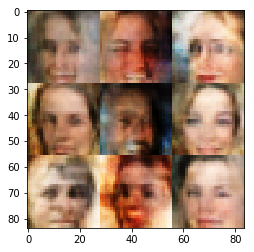

Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.2132
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 1.0513


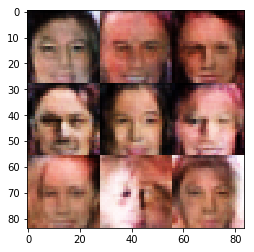

Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.8748


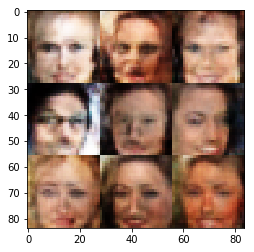

Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.8825


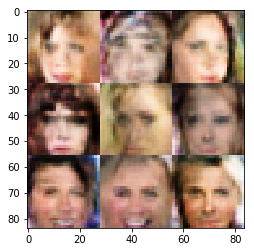

Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 1.0907
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.9480


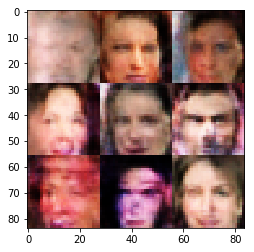

Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 1.2163
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 1.0054


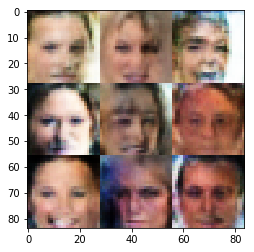

Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.2132
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7736


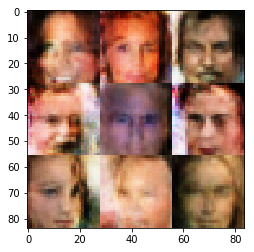

Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.2379


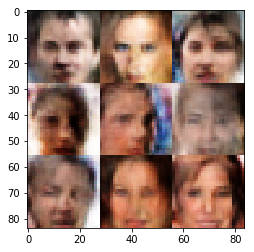

Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 0.8950... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 1.1747
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.1652


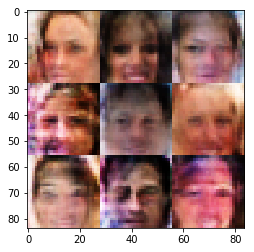

Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 1.2283
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 1.2799
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.1276


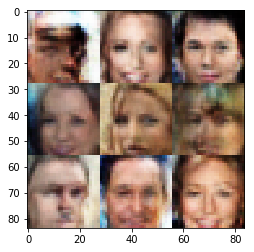

Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 1.1220
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.9612


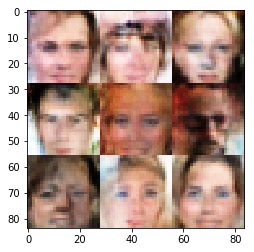

Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.1333
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.2015
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7266


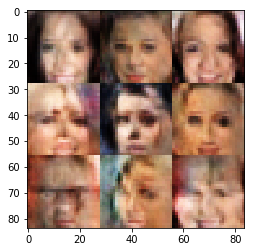

Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 1.0761


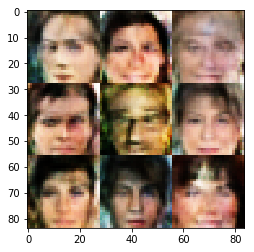

Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 1.0694
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 1.1966
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.6729


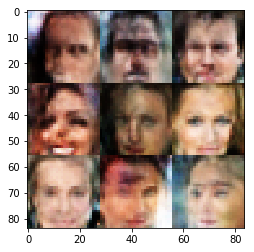

Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 1.0734
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.9030


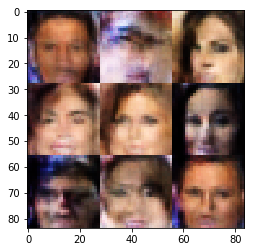

Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.9411


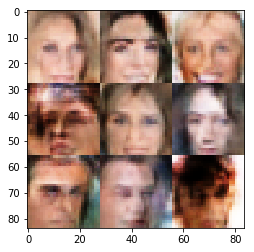

Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 1.1352
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.1147
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 0.7600


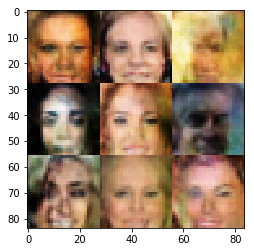

Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 1.0700
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.8342


In [239]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.